In [137]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as plt
import math
import theano
import theano.tensor as tt
from scipy import stats
from scipy.special import expit as logistic
from scipy.special import logit
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import auc, mean_squared_error, roc_curve, roc_auc_score, accuracy_score



import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import arviz as az

import os

import sys
sys.path.insert(0, '/Users/amirgavrieli/PycharmProjects/statrethink_course_in_pymc3')
sys.path.insert(0, '/Users/amirgavrieli/PycharmProjects/COVID19-ISRAEL')

In [47]:
fig_dir = '/Users/amirgavrieli/Desktop/Graduate/Tel_Aviv_University_Courses/Uri_Shalit/project/figures'

# Data proccesing 

In [2]:
# bangladesh v2 data
dir_path = '/Users/amirgavrieli/Downloads/BDBR72DT'
suffix = 'BDBR72FL.DTA'
path = os.path.join(dir_path, suffix)
dv2 = pd.read_stata(path)

In [3]:
print(f' there are {dv2.shape[0]} surveys with {dv2.shape[1]} features')

 there are 43772 surveys with 1159 features


In [4]:
dv2.drop_duplicates(keep='first', inplace=True)

In [5]:
print(f' there are {dv2.shape[0]} surveys after droping duplicates')

 there are 43772 surveys after droping duplicates


In [6]:
# v025 : rural urban
# v106 : No education, Primary, Secondary, and Higher
# V312 : Current contraceptive method
# v313 : modern method, a traditional method, or a folkloric method
# v315 month started taking contraceptive
# v316 year started taking contraceptive
column_dict = {'v010':'yob', 'v012':'age', 'v020':'ever_married',
               'v025':'urban','v106':'education',  'v201':'children', 
               'v312':'contraceptive_current', 'v313': 'contraceptive_type',
              'caseid':'id'}

In [7]:
d2 = dv2[[c for c in column_dict.keys()]]
d2 = d2.rename(columns=column_dict).copy()
d2['Y'] = np.where(d2.contraceptive_current != 'not using',1,0)
d2['urban_bol'] = np.where(d2.urban == 'urban',1,0)
d2['id'] = (dv2['caseid'].astype(str)
            .apply(lambda x: x.split(' '))
            .apply(lambda x: ''.join(x))
            .astype(int))
edu_dict = {'no education':0, 'primary':1, 'secondary':2, 'higher':3}
d2['education_ord'] = d2.education.replace(edu_dict)
d2['T'] = np.where((d2.education_ord >=2) ,1,0)

In [8]:
print(f' there are {d2.id.nunique()} unique women in the survey with {d2.shape[0]} surveys')

 there are 15927 unique women in the survey with 43772 surveys


In [9]:
d2_dup = d2[d2.duplicated(subset='id',keep=False)]

In [10]:
print(f' there are {d2_dup.id.nunique()} women with multiple surveys')

 there are 12007 women with multiple surveys


##### We will drop duplicates on the limited columns

In [11]:
d2.drop_duplicates(keep='first', inplace=True)

In [12]:
print(f' there are {d2.shape[0]} unique surveys of {d2.id.nunique()}')

 there are 16079 unique surveys of 15927


In [13]:
d2_dup = d2[d2.duplicated(subset='id',keep=False)]

In [14]:
print(f' there are {d2_dup.id.nunique()} women with multiple surveys after droping duplicates')

 there are 149 women with multiple surveys after droping duplicates


In [15]:
tmp = d2_dup.groupby('id').education_ord.count().reset_index()
tmp2 = tmp[tmp.duplicated(keep=False)]
print(f' There are {tmp2.shape[0]} women who changed their education during the time of the survey')

 There are 0 women who changed their education during the time of the survey


In [16]:
tmp = d2_dup.groupby('id').Y.count().reset_index()
tmp2 = tmp[tmp.duplicated(keep=False)]
print(f'  there are {tmp2.shape[0]} women who changed her contraceptive use between surveys')

  there are 0 women who changed her contraceptive use between surveys


In [17]:
d2.drop_duplicates(subset='id',keep='first', inplace=True)
print(f'We are left with {d2.shape[0]} surveys of {d2.id.nunique()} women')

We are left with 15927 surveys of 15927 women


# Data description

In [36]:
from src.Table1.table1_global import make_table1
from src.Table1.defs import *

In [37]:
d2.columns

Index(['yob', 'age', 'ever_married', 'urban', 'education', 'children',
       'contraceptive_current', 'contraceptive_type', 'id', 'Y', 'urban_bol',
       'education_ord', 'T'],
      dtype='object')

In [70]:
TABLE_COLS = ['yob', 'age',  'children', 'T', 'urban_bol', 'Y']

TABLE_LABELS =['Year of birth', 'Age', 'Number of children', 
               'Secondary education or higher', 'Urban', 'Using contraception']

TABEL_COLS_TYPE = ['continuous','continuous', 'continuous', 'continuous','continuous','continuous' ]

TX_labels = {'1': 'Using contraception', '0': 'Not using contraception'}

TX_col = 'Y'

In [71]:
table1 = (
    make_table1(d2, TABLE_COLS, TABLE_LABELS, TABEL_COLS_TYPE, TX_col, TX_labels, decimals=2).dropna(axis=1))
table1.columns = ['All patients', 'Using contraception' ,'Not using contraception']

In [72]:
round(table1,2)

,All patients,Using contraception,Not using contraception
N,"15,927","6,007 (37.72%)","9,920 (62.28%)"
Year of birth,"1,981.62 (8.83)","1,979.81 (9.74)","1,982.71 (8.04)"
Age,32.09 (8.82),33.89 (9.73),31.0 (8.03)
Number of children,2.72 (1.63),2.81 (1.82),2.66 (1.5)
Secondary education or higher,0.45 (0.5),0.4 (0.49),0.47 (0.5)
Urban,0.34 (0.47),0.32 (0.47),0.35 (0.48)
Using contraception,0.62 (0.48),0.0 (0.0),1.0 (0.0)


In [74]:
table1.to_csv(os.path.join(fig_dir,'table1.csv'))

In [98]:
education_table = d2[['Y','education_ord']].groupby('education_ord').Y.sum().reset_index()
education_table['education_ord_all_sum'] = d2[['Y','education_ord']].groupby('education_ord').Y.count()
education_table['not_Y'] = education_table.education_ord_all_sum - education_table.Y
education_table['Y_prop'] = education_table.Y / education_table.education_ord_all_sum 
education_table

,education_ord,Y,education_ord_all_sum,not_Y,Y_prop
0,0,2231,4017,1786,0.555390
1,1,3006,4818,1812,0.623910
2,2,3773,5766,1993,0.654353
3,3,910,1326,416,0.686275


In [100]:
print(f' 69% of higher education use contraception')

 69% of higher education use contraception


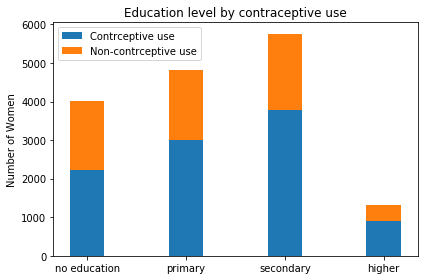

In [97]:

width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(education_table.education_ord, education_table.Y, width)
p2 = plt.bar(education_table.education_ord, education_table.not_Y, width,
             bottom=education_table.Y)

plt.ylabel('Number of Women')
plt.title('Education level by contraceptive use')
plt.xticks(education_table.education_ord, ('no education', 'primary', 'secondary', 'higher'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Contrceptive use', 'Non-contrceptive use'))

plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'Education_level_by_contraceptive_use.png'))

# Helper functions

In [102]:
def calc_propensity_score_sklearn_LR(X,T):

    model = LogisticRegression(max_iter=500)
    ps_model = model.fit(X=X, y=T)
    pscores = ps_model.predict_proba(X)[:,1]
    
    return ps_model, pscores
    
def plot_pscores(data, title='propensity score of data LR'):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=plt.figaspect(0.5))
      
    labels = [0,1]
    data_0 = data[data['T']==0]
    data_1 = data[data['T']==1]
    N_0 = data_0.shape[0]
    N_1 = data_1.shape[0]

    pscores_treated = data_1.ps
    ax = sns.kdeplot(pscores_treated, shade=True, label=f'T={labels[1]} N=({N_1})', ax=ax, cut=3)
    pscores_not_treated = data_0.ps
    ax = sns.kdeplot(pscores_not_treated, shade=True, label=f'T={labels[0]} N=({N_0})', ax=ax)
    ax.set_title(title)
    ax.legend(loc="best")
    
    fig.savefig(os.path.join(fig_dir, title+'.png'))

In [20]:
d22 = d2[['yob', 'age','children','T', 'urban_bol', 'Y']]

In [21]:
X1 = d22[['yob', 'age','children', 'urban_bol']].copy()
T1 = d22['T'] 
Y1 = d22['Y']

## Propensity Score - using Logistic Regression  

In [22]:
ps_model, pscores = calc_propensity_score_sklearn_LR(X=X1, T=T1)
data1_copy = d22.copy()
data1_copy['ps'] = pscores

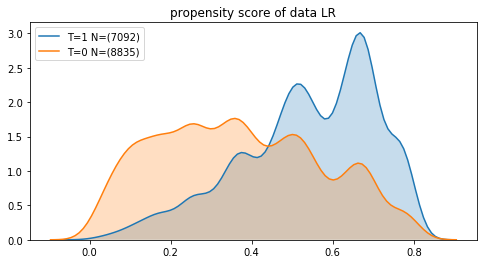

In [103]:
plot_pscores(data=data1_copy)

# Matching 

In [108]:
def plot_pscores2(datasets, titles=['propensity score of data LR','propensity score of data2 LR']):
    ncols = len(datasets)
    fig, ax = plt.subplots(nrows=1,ncols=ncols, figsize=plt.figaspect(0.5))
    for i, data in enumerate(datasets):      
        labels = [0,1]
        data_0 = data[data['T']==0]
        data_1 = data[data['T']==1]
        N_0 = data_0.shape[0]
        N_1 = data_1.shape[0]
        
        pscores_treated = data_1.ps
        ax[i] = sns.kdeplot(pscores_treated, shade=True, label=f'T={labels[1]} N=({N_1})', ax=ax[i])
        pscores_not_treated = data_0.ps
        ax[i] = sns.kdeplot(pscores_not_treated, shade=True, label=f'T={labels[0]} N=({N_0})', ax=ax[i])
        ax[i].set_title(titles[i])
        ax[i].legend(loc="best")
    
        fig.savefig(os.path.join(fig_dir, 'Propensity score before and after matching.png'))

In [106]:
def find_propensity_score_matches(X, TX_col, pscore_col, caliper=0.25, distance='linear'):
    """
    Treatment group should be smaller
    """
    
    idx_A0 = X[TX_col]==0
    idx_A1 = X[TX_col]==1
    
    X_T1, X_T0 = X[idx_A1].copy(), X[idx_A0].copy()
    N1, N0 = len(X_T1), len(X_T0)
    g1, g0 = X_T1.loc[:,pscore_col].copy(),  X_T0.loc[:,pscore_col].copy()
    
    # get caliper_value (default is 0.25 logit stdevs
    caliper_value = caliper * logit(X[pscore_col]).std()

    # Randomly permute the smaller group to get order for matching
    g1_idx_order = np.random.permutation(g1.index)
    for g1_idx in g1_idx_order:
        
        if distance=='linear': # linear propensity score (on the logits)
            dist = np.abs(logit(g1[g1_idx]) - logit(g0))
        else: # regular propensity score
            dist = np.abs(g1[g1_idx] - g0)
        
        
        if dist.min() <= caliper_value:
            g0_idx = dist.idxmin()
            X_T1.loc[g1_idx, 'matched_control_idx'] = g0_idx
            X_T0.loc[g0_idx, 'matched_control_idx'] = g0_idx
            g0 = g0.drop(g0_idx)
        else:
            X_T1.loc[g1_idx, 'matched_control_idx'] = np.nan        
            
    X_matched = pd.concat([X_T1, X_T0])
    return X_matched

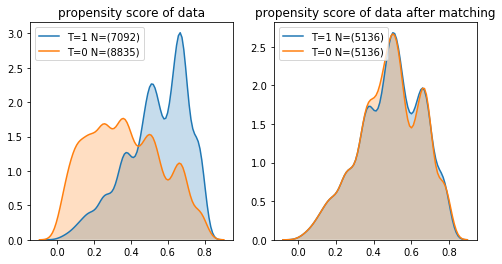

In [109]:
data_matched = find_propensity_score_matches(data1_copy, 'T', 'ps', caliper=0.25, distance='linear')
data_matched.dropna(subset=['matched_control_idx'],inplace=True)
plot_pscores2(datasets=[data1_copy,data_matched],titles=['propensity score of data','propensity score of data after matching'])

# Estimating ATT

In [110]:
ATT_pd = pd.DataFrame(columns=['Type','data1'])
att_dict1 = {}

# Estimating ATT by Inverse Propensity Score Weighting (IPW)

Under ignorability for ATE we use the following formula:
\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}{\frac{y_i t_i}{e_i}} - \frac{1}{n}\sum_{i=1}^{n}{\frac{y_i (1-t_i)}{1-e_i}}
\end{equation}

The weights described previously ($w_ATE= \frac{Z}{e} +\frac{1-Z}{1-e}$) permit estimation of the ATE. However, a different set of weights permit estimation of the average treatment effect in the treated (ATT): $w_ATT = Z +\frac{e \cdot(1−Z)}{1 − e}$[18]. These weights are obtained by multiplying the conventional weights by e , so that treated subjects receive a weight of one. Thus, the treated sample is being used as the reference population to which the treated and control samples are being standardized. While the current article is focused on the use of the ATE weights, the balance diagnostics discussed are equally applicable to situations in which the ATT weights are employed.

So We calculate:

\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}{y_i t_i} - \frac{1}{n}\sum_{i=1}^{n}{y_i (1-t_i) \frac{e_i}{1-e_i}}
\end{equation}

In [111]:
ATE1 = (Y1*T1*(1/data1_copy.ps)).mean() - (Y1*(1-T1)*(1/(1-data1_copy.ps))).mean()
print(f"The estimated ATE for data1 using IPW is {ATE1}")
ATT1 = (Y1*T1).mean() - (Y1*(1-T1)*(data1_copy.ps/(1-data1_copy.ps))).mean()
print(f"The estimated ATT for data1 using IPW is {ATT1}")

att_dict1['IPW'] =ATT1

The estimated ATE for data1 using IPW is 0.040815650441747175
The estimated ATT for data1 using IPW is 0.02136026604603275


# Estimating ATT using Matching

I use K-nearest neighbors as described here https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/ "..Nearest neighbor matching nearly always estimates the ATT, as it matches control individuals to the treated group and discards controls who are not selected as matches."

### Using Uber matching


In [112]:
data1_copy.columns

Index(['yob', 'age', 'children', 'T', 'urban_bol', 'Y', 'ps'], dtype='object')

In [113]:
from causalml.match import NearestNeighborMatch, create_table_one

psm = NearestNeighborMatch(replace=False,
                           ratio=1,
                           random_state=42)

features = data1_copy.drop(columns=['Y','T'])
covariates = features.columns.tolist()

matched1 = psm.match(data=data1_copy,treatment_col='T',score_cols=['ps'])

In [114]:
ATT1 = (matched1.Y*matched1['T'] - matched1.Y*(1-matched1['T'])).mean()
print(f"The estimated ATT for data1 using 1:1 matching on ps is {ATT1}")
att_dict1['1:1 ps matching'] =ATT1

The estimated ATT for data1 using 1:1 matching on ps is 0.02729064039408867


### Using my code

In [115]:
ATT1 = (data_matched.Y*data_matched['T'] - data_matched.Y*(1-data_matched['T'])).mean()
print(f"The estimated ATT for data1 using 1:1 matching on ps is {ATT1}")
att_dict1['1:1 ps matching'] =ATT1

The estimated ATT for data1 using 1:1 matching on ps is 0.02453271028037383


# Estimating ATT using S-Learner

S-learner (single): fit a model with $t$ as feature on the entire sample:
\begin{equation}
y \approx \hat{f}(x,t) \\
ATT \approx \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,1)} - \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,0)}
\end{equation}

In [134]:
train1, test1 = train_test_split(d22,test_size=0.33)

x_train1, t_train1, y_train1 = train1.drop(columns=['T','Y']), train1['T'],train1['Y']
x_test1, t_test1, y_test1 = test1.drop(columns=['T','Y']), test1['T'],test1['Y']


In [135]:
d22.columns

Index(['yob', 'age', 'children', 'T', 'urban_bol', 'Y'], dtype='object')

## Logistic Regression

In [136]:
sc = preprocessing.StandardScaler()

x_train1[['yob', 'age', 'children']] = sc.fit_transform(x_train1[['yob', 'age', 'children']])
x_test1[['yob', 'age', 'children']] = sc.fit_transform(x_test1[['yob', 'age', 'children']])

In [140]:
LogReg_clf = LogisticRegression()
LogReg_clf.fit(x_train1.join(t_train1),y_train1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [171]:
LogReg_clf.coef_

array([[ 0.39870016, -0.0350067 ,  0.19217476,  0.21436387,  0.14153207]])

In [141]:
accuracy = accuracy_score(LogReg_clf.predict(x_test1.join(t_test1)),y_test1)

In [144]:
print(f"accuracy on the test set with LR is {round(accuracy,2)}")

accuracy on the test set with LR is 0.66


In [160]:
cols_to_drop = ['T', 'Y']
d22_scaled = d22.copy()
d22_scaled[['yob', 'age', 'children']] = sc.fit_transform(d22_scaled[['yob', 'age', 'children']])

In [163]:
X11 = d22_scaled[d22_scaled['T']==1].drop(columns=cols_to_drop)
Y11 = d22_scaled[d22_scaled['T']==1].Y

X11t = X11.copy()
X11t['T']=1

X11nt = X11.copy()
X11nt['T']=0


In [164]:
ATT1 = (LogReg_clf.predict(X11t)-LogReg_clf.predict(X11nt)).mean()
print(f"The estimated ATT using S-learner (LR) is {ATT1}")
att_dict1['S-learner (LR)'] =ATT1

The estimated ATT using S-learner (LR) is 0.03990411731528483


In [169]:
pdatt = pd.DataFrame.from_dict(att_dict1,orient='index', columns=['ATT'])
round(pdatt,4)

,ATT
IPW,0.0214
1:1 ps matching,0.0245
S-learner (LR),0.0399


In [170]:
pdatt.to_csv(os.path.join(fig_dir,'att_table.csv'))